In [1]:
import numpy as np
import dolfinx
import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import CellType, GhostMode
from ufl import (CellDiameter, FacetNormal, avg, div, dS, dx, grad, inner,
                 jump, pi, sin,cos, exp)
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 div, dx, ds, grad, inner, derivative)

from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import numpy as np
import matplotlib.pyplot as plt
from dolfinx import fem, io, mesh, plot

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm'  # Short for Computer Modern, the default LaTeX font
})

from dolfinx import fem
import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt



[Andreas-MacBook-Pro-3.local:08563] shmem: mmap: an error occurred while determining whether or not /var/folders/yj/8cjwpc950wvc5bs1vtj2dn7h0000gn/T//ompi.Andreas-MacBook-Pro-3.501/jf.0/2723807232/sm_segment.Andreas-MacBook-Pro-3.501.a25a0000.0 could be created.


In [2]:
#check version of dolfinx
import dolfinx
print(dolfinx.__version__)

0.9.0


In [3]:
# First we import the data fro the source term coming from PyBaMM. They act as a source in our FE problem
data = np.load('FA_data.npz')
FA = data['FA']
Y = data['Y']
Z = data['Z']

In [4]:
# Define some parameters fo the CC:
thickness = 1*10**(-5)
poisson_ratio = 0.2
u0 = 0 #the total displacement in one batteyr layer (clamped)

In [5]:
l = 0.207 # length of the battery
h = 0.137 # height of the battery

# Create mesh
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0, 0), ( l, h)), n=(102, 102),
                            cell_type=CellType.triangle,
                            ghost_mode=GhostMode.shared_facet)

# Create function space
V = fem.functionspace(msh, ("Lagrange", 2))


facets = mesh.locate_entities_boundary(msh, dim=1,
                                       marker=lambda x: np.logical_or.reduce((
                                           np.isclose(x[0], 0),
                                           np.isclose(x[0], l),
                                           np.isclose(x[1], 0),
                                           np.isclose(x[1], h)))) # Find the facets on the boundary of the domain

# We now find the degrees-of-freedom that are associated with the
# boundary facets using {py:func}`locate_dofs_topological
# <dolfinx.fem.locate_dofs_topological>`

dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

# and use {py:func}`dirichletbc <dolfinx.fem.dirichletbc>` to create a
# {py:class}`DirichletBC <dolfinx.fem.DirichletBC>`
# class that represents the boundary condition. In this case, we impose
# Dirichlet boundary conditions with value $0$ on the entire boundary
# $\partial\Omega$.

bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)



# First, the penalty parameter $\alpha$ is defined. In addition, we define a
# variable `h` for the cell diameter $h_E$, a variable `n`for the
# outward-facing normal vector $n$ and a variable `h_avg` for the
# average size of cells sharing a facet
# $\left< h \right> = \frac{1}{2} (h_{+} + h_{-})$. Here, the UFL syntax
# `('+')` and `('-')` restricts a function to the `('+')` and `('-')`
# sides of a facet.

alpha = ScalarType(8.0)
h = CellDiameter(msh)
n = FacetNormal(msh)
h_avg = (h('+') + h('-')) / 2.0

In [6]:
average_alpha = np.mean(FA)
average_alpha/10000000

np.float64(-3.073055208454348)

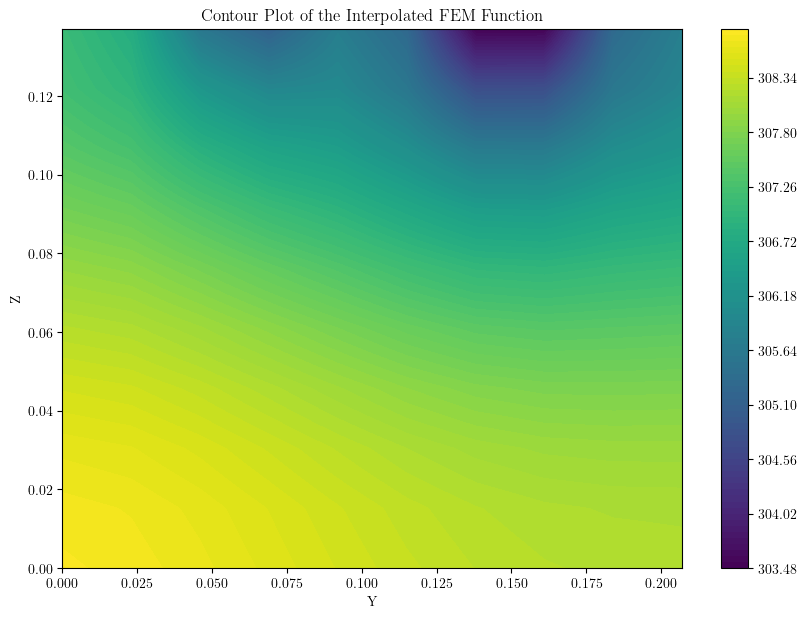

In [7]:
# We now interpolate the FA fucntion to the mesh.
# Create a function space for the source term

V = fem.functionspace(msh, ("Lagrange", 2))

# Create a function to hold the source term
source_function = fem.Function(V)

# Prepare the points and values for interpolation
points = np.array([Y.flatten(), Z.flatten()]).T  # Reshape Y and Z to a list of points
values = - thickness * FA.flatten()  # Flatten Ff values

def your_expression(x):
    # Use x[1] and x[2] assuming the data is in the Y-Z plane and x[0] is X
    yz_points = np.array([x[1], x[2]]).T  # Prepare the points where we want to interpolate
    
    # Interpolate the values at the given points using griddata
    # Choose the interpolation method that best suits your data ('linear', 'nearest', 'cubic')
    interpolated_values = griddata(points, values, yz_points, method='linear')
    
    # griddata returns an array, but we want single values for each point x
    # If yz_points is a single point, interpolated_values will be a single-element array
    return interpolated_values[0] if interpolated_values.size == 1 else interpolated_values

source_function.interpolate(your_expression)

# Step 1: Create a grid over the domain in the Y-Z plane
y_min, y_max = Y.min(), Y.max()
z_min, z_max = Z.min(), Z.max()
resolution = 500  # Choose an appropriate resolution for your grid
y_grid, z_grid = np.meshgrid(np.linspace(y_min, y_max, resolution), np.linspace(z_min, z_max, resolution))

# Step 2: Evaluate the source_function at each grid point
# Since we can't directly evaluate source_function at arbitrary points, we'll use the original points and values
fem_values = griddata(points, values, (y_grid, z_grid), method='linear')

# Step 3: Plot the contours
plt.figure(figsize=(10, 7))
contour_levels = 100  # Adjust based on desired detail
contour_plot = plt.contourf(y_grid, z_grid, fem_values, levels=contour_levels, cmap='viridis')
plt.colorbar(contour_plot)
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Contour Plot of the Interpolated FEM Function')
plt.show()

In [8]:


# After that, we can define the variational problem consisting of the bilinear
# form $a$ and the linear form $L$. The source term is prescribed from FA. Note that with `dS`, integration is
# carried out over all the interior facets $\mathcal{E}_h^{\rm int}$, whereas
# with `ds` it would be only the facets on the boundary of the domain, i.e.
# $\partial\Omega$. The jump operator
# $[\!\![ w ]\!\!] = w_{+} \cdot n_{+} + w_{-} \cdot n_{-}$ w.r.t. the
# outward-facing normal vector $n$ is in UFL available as `jump(w, n)`.

# +
# Define variational problem
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = ufl.div(ufl.grad((1-poisson_ratio)/2 * source_function))


from ufl import Measure

from ufl import ds

a = inner(div(grad(u)), div(grad(v))) * dx \
    - inner(avg(div(grad(u))), jump(grad(v), n)) * dS \
    - inner(jump(grad(u), n), avg(div(grad(v)))) * dS \
    + alpha / h_avg * inner(jump(grad(u), n), jump(grad(v), n)) * dS
a += - div(grad(u)) * inner(grad(v), n) * ds \
    - div(grad(v)) * inner(grad(u), n) * ds \

L = inner(f, v) * dx

In [9]:
# We create a {py:class}`LinearProblem <dolfinx.fem.petsc.LinearProblem>`
# object that brings together the variational problem, the Dirichlet
# boundary condition, and which specifies the linear solver. In this
# case we use a direct (LU) solver. The {py:func}`solve
# <dolfinx.fem.petsc.LinearProblem.solve>` will compute a solution.

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [10]:
# The solution can be written to a  {py:class}`XDMFFile
# <dolfinx.io.XDMFFile>` file visualization with ParaView or VisIt

with io.XDMFFile(msh.comm, "out_biharmonic/biharmonic.xdmf", "w") as file:
    V1 = fem.functionspace(msh, ("Lagrange", 1))
    u1 = fem.Function(V1)
    u1.interpolate(uh)
    file.write_mesh(msh)
    file.write_function(u1)

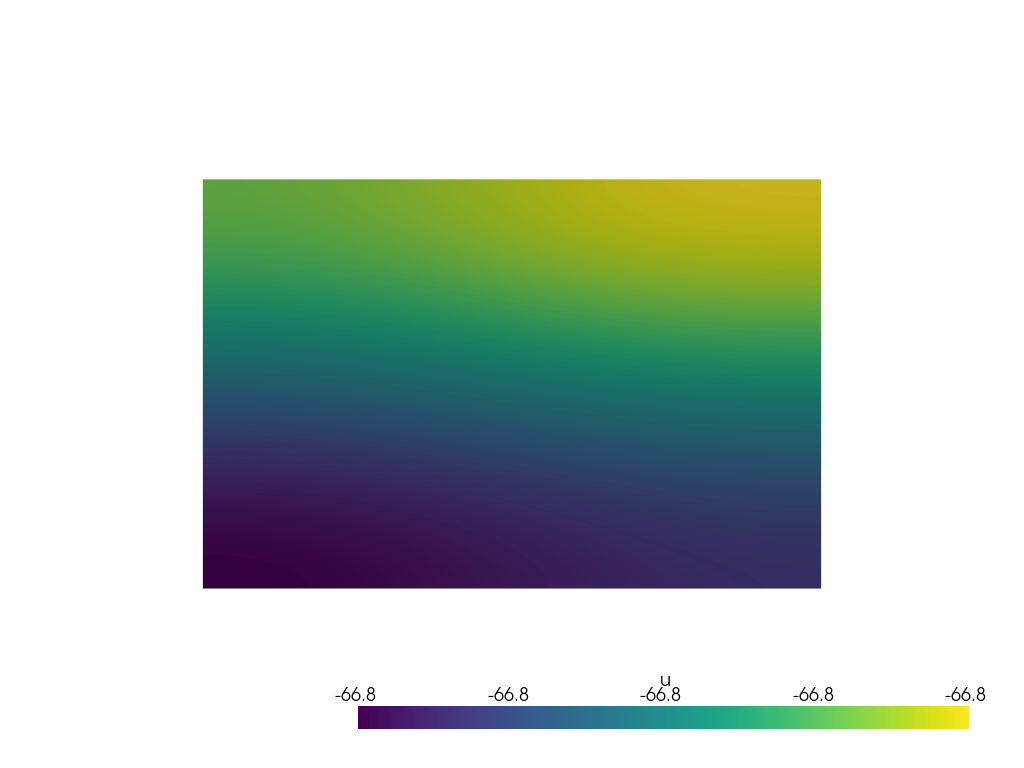

In [11]:
import numpy as np
import pyvista

# Step 1: Interpolate uh from V (P2) to V1 (P1)
V1 = fem.functionspace(msh, ("Lagrange", 1))
uh_vis = fem.Function(V1)
uh_vis.interpolate(uh)

# Step 2: Build the PyVista mesh
coordinates = msh.geometry.x
connectivity = msh.topology.connectivity(msh.topology.dim, 0).array
num_cells = connectivity.shape[0] // 3
triangles = connectivity.reshape((num_cells, 3))
cells = np.hstack([np.full((num_cells, 1), 3), triangles]).flatten()

# Step 3: Build the UnstructuredGrid
grid = pyvista.UnstructuredGrid(cells, np.full(num_cells, pyvista.CellType.TRIANGLE), coordinates)

# Step 4: Attach P1 solution data
grid.point_data["u"] = uh_vis.x.array.real
grid.set_active_scalars("u")

# Step 5: Plot
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=False)
plotter.view_xy()
plotter.xlabel = 'x'
plotter.ylabel = 'y'
plotter.show()


EVALUATE STRESSES

In [12]:
from ufl import *

def stress_yy(v):
    return ( v.dx(0).dx(0) + source_function) 

def stress_xx(v):
    return ( v.dx(1).dx(1) + source_function)

def stress_xy(v):
    return (- 2 * v.dx(0).dx(1))

In [13]:
sT_yy = stress_yy(uh)
sT_xx = stress_xx(uh)
sT_xy = stress_xy(uh)

In [14]:
W =fem.functionspace(msh, ("Lagrange", 2))

sT_xx_expr = fem.Expression(sT_xx, W.element.interpolation_points())
sT_xx_h = fem.Function(W)
sT_xx_h.interpolate(sT_xx_expr)

sT_yy_expr = fem.Expression(sT_yy, W.element.interpolation_points())
sT_yy_h = fem.Function(W)
sT_yy_h.interpolate(sT_yy_expr)

sT_xy_expr = fem.Expression(sT_xy, W.element.interpolation_points())
sT_xy_h = fem.Function(W)
sT_xy_h.interpolate(sT_xy_expr)


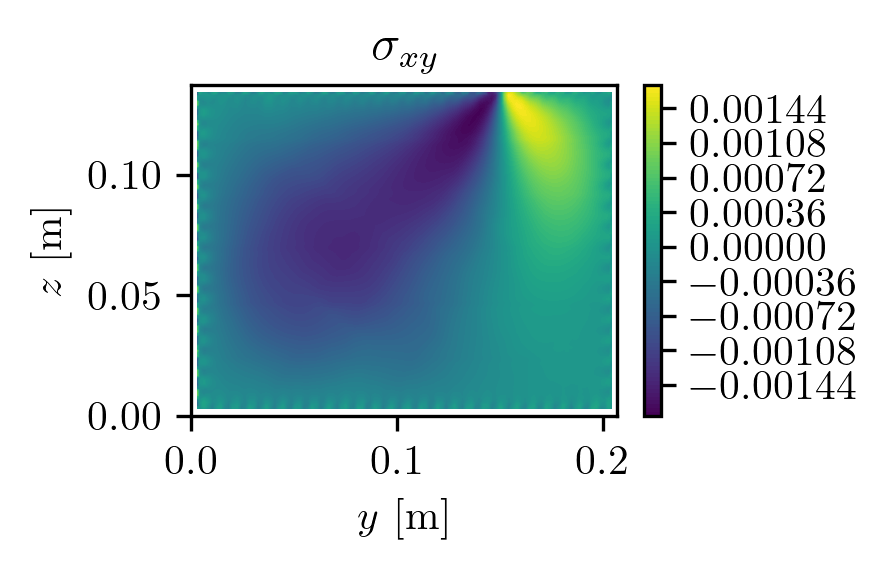

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Step 1: Interpolate stress to P1 space
V1 = fem.functionspace(msh, ("Lagrange", 1))
sT_xy_vis = fem.Function(V1)
sT_xy_vis.interpolate(sT_xy_h)

# Step 2: Use P1 geometry nodes and values
coordinates = msh.geometry.x
s_values = sT_xy_vis.x.array.real

# Extract x and y coordinates
x_coords, y_coords = coordinates[:, 0], coordinates[:, 1]

# Step 3: Grid limits
x_min, x_max = x_coords.min() + 0.003, x_coords.max() - 0.003
y_min, y_max = y_coords.min() + 0.003, y_coords.max() - 0.003

# Step 4: Create regular grid for interpolation
xi, yi = np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500)
xi, yi = np.meshgrid(xi, yi)

# Step 5: Interpolate using griddata
zi = griddata((x_coords, y_coords), s_values, (xi, yi), method='linear')

# Step 6: Plot
plt.figure(figsize=(3, 2), dpi=300)
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
#set plot limits
plt.xlim(0, 0.207)
plt.ylim(0, 0.137)
plt.colorbar()
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.title(r"$\sigma_{xy}$")
plt.tight_layout()
plt.show()


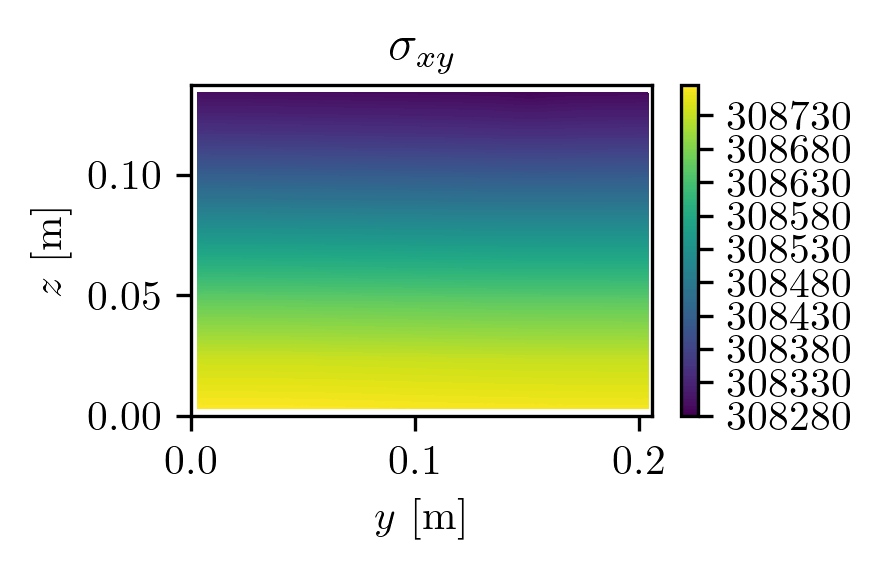

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Step 1: Interpolate stress to P1 space
V1 = fem.functionspace(msh, ("Lagrange", 1))
sT_yy_vis = fem.Function(V1)
sT_yy_vis.interpolate(sT_yy_h)

# Step 2: Use P1 geometry nodes and values
coordinates = msh.geometry.x
s_values = sT_yy_vis.x.array.real

# Extract x and y coordinates
x_coords, y_coords = coordinates[:, 0], coordinates[:, 1]

# Step 3: Grid limits
x_min, x_max = x_coords.min() + 0.003, x_coords.max() - 0.003
y_min, y_max = y_coords.min() + 0.003, y_coords.max() - 0.003

# Step 4: Create regular grid for interpolation
xi, yi = np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500)
xi, yi = np.meshgrid(xi, yi)

# Step 5: Interpolate using griddata
zi = griddata((x_coords, y_coords), s_values, (xi, yi), method='linear')

# Step 6: Plot
plt.figure(figsize=(3, 2), dpi=300)
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
plt.colorbar()
plt.xlim(0, 0.206)
plt.ylim(0, 0.137)
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.title(r"$\sigma_{xy}$")
plt.tight_layout()
plt.show()


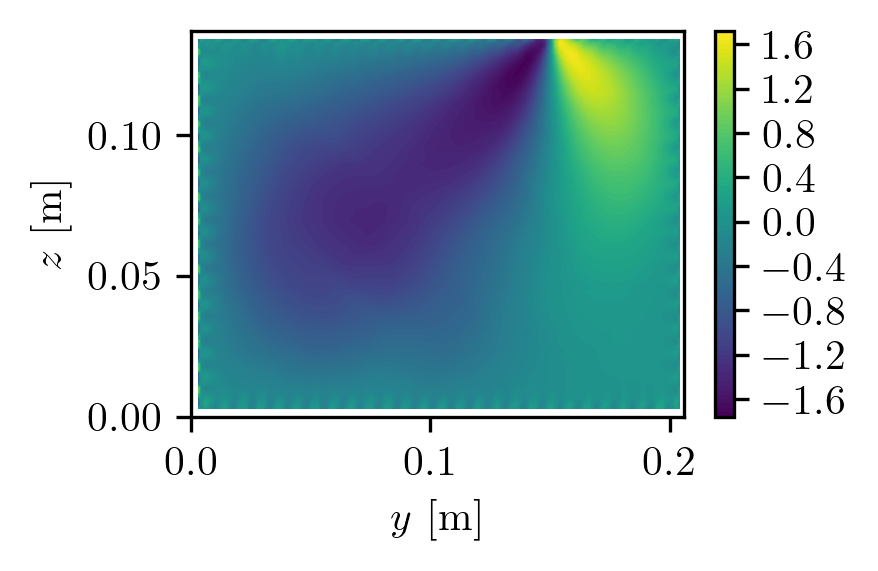

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Step 1: Interpolate sT_xy_h to P1 space
V1 = fem.functionspace(msh, ("Lagrange", 1))
sT_xy_vis = fem.Function(V1)
sT_xy_vis.interpolate(sT_xy_h)

# Step 2: Get P1 geometry and values
coordinates = msh.geometry.x
s_values = sT_xy_vis.x.array.real

x_coords, y_coords = coordinates[:, 0], coordinates[:, 1]

# Step 3: Define interpolation gri
x_min, x_max = x_coords.min() + 0.003, x_coords.max() - 0.003
y_min, y_max = y_coords.min() + 0.003, y_coords.max() - 0.003
xi, yi = np.linspace(x_min, x_max, 2000), np.linspace(y_min, y_max, 2000)
xi, yi = np.meshgrid(xi, yi)

# Step 4: Interpolate
zi = griddata((x_coords, y_coords), s_values, (xi, yi), method='linear')*1000

# Step 5: Plot
plt.figure(figsize=(3, 2), dpi=300)
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
plt.colorbar(ticks=[1.6,1.2,0.8,0.4, 0,-1.2,-0.8,-0.4,-1.6])
plt.xlim(0, 0.206)
plt.ylim(0, 0.137)
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.tight_layout()
plt.show()


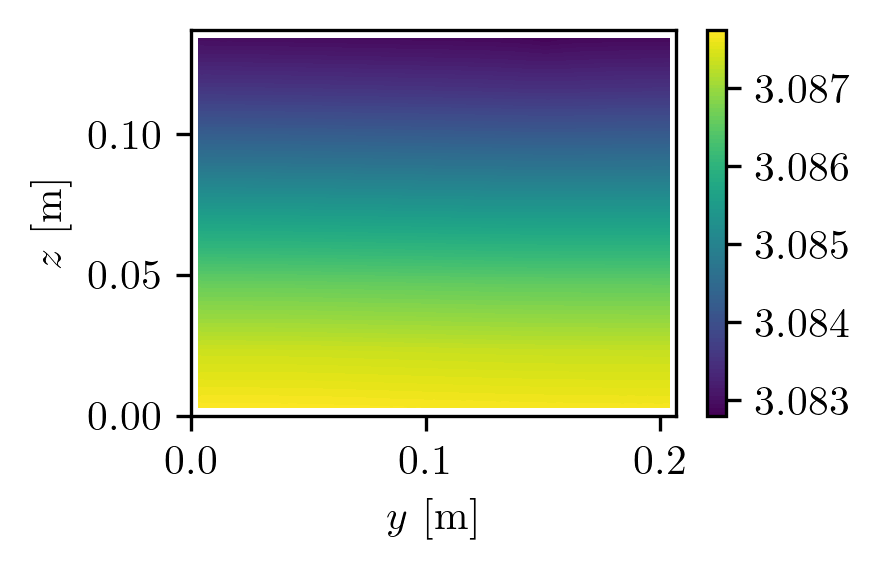

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Step 1: Interpolate sT_yy_h to P1 space
V1 = fem.functionspace(msh, ("Lagrange", 1))
sT_yy_vis = fem.Function(V1)
sT_yy_vis.interpolate(sT_yy_h)

# Step 2: Get P1 geometry and values
coordinates = msh.geometry.x
s_values = sT_yy_vis.x.array.real

x_coords, y_coords = coordinates[:, 0], coordinates[:, 1]

# Step 3: Define interpolation gri
x_min, x_max = x_coords.min() + 0.003, x_coords.max() - 0.003
y_min, y_max = y_coords.min() + 0.003, y_coords.max() - 0.003
xi, yi = np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000)
xi, yi = np.meshgrid(xi, yi)

# Step 4: Interpolate
zi = griddata((x_coords, y_coords), s_values, (xi, yi), method='linear')/100

# Step 5: Plot
plt.figure(figsize=(3, 2), dpi=300)
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
plt.colorbar(ticks= np.linspace(3.082,3.087,6))
plt.xlim(0, 0.207)
plt.ylim(0, 0.137)
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.tight_layout()
plt.show()
